### Namestitev potrebnih knjižnic za delovanje programa

In [1]:
%pip install lxml
%pip install openpyxl
%pip install matplotlib
%pip install beautifulsoup4
%pip install pandas
%pip install requests
%pip install seaborn
%pip install selenium


[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: pip3 install --upgrade pi

# POMEMBNO!

- v primeru da v mapi že obsataja datoteka "laliga_all_seasons.xlsx", jo je priporočljivo izbrisati. Drugače lahko pride do napake pri shranjevanju rezultatov analize, saj lahko nekateri listi že obstajajo in program ne bo mogel dodati novih.
- ko se poganja koda, ki upodablja excel dokument "laliga_all_seasons.xlsx", dokument ne sme biti odprt, saj program ne more brati/pisati v datoteko, če je odprta.

In [2]:
# vključimo potrebne knjižnice za delovanje našega programa
import requests
from bs4 import BeautifulSoup
import pandas as pd
import csv
import os
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from bs4 import BeautifulSoup
import pandas as pd
from selenium.webdriver.chrome.options import Options

FILE_NAME = "laliga_all_seasons.xlsx"
ALL_DATA_SHEET = "All seasons Laliga data"

podatki =[]
def zamenjaj_naslove(imena_stolpcev):
    # spletna stran s katere bomo prebrali podatke ima v glavi tabele krajšave npr. MP - match played.
    # krajšave bomo nadomestili v berlivejše podatke
    naslovi = {
        "MP": "Matches Played",
        "W": "Wins",
        "D": "Draws",
        "L": "Losses",
        "F": "Goals for",
        "A": "Goals against",
        "D": "Goal difference",
        "P": "Points",
        "#": "Position",
        
    }
    
    return [naslovi.get(stolpec, stolpec) for stolpec in imena_stolpcev]
def pridobivanje_podatkov_z_url(url):
    chrome_options = Options()
    chrome_options.add_argument("--disable-search-engine-choice-screen")
    driver = webdriver.Chrome(options=chrome_options)

    # pridobivanje spletne strani
    driver.get(url)
    driver.implicitly_wait(10)  

    html_content = driver.page_source

    # zaprtje gonilnika
    driver.quit()

    # razčlenimo HTML z uporabo BeautifulSoup
    soup = BeautifulSoup(html_content, 'lxml')

    # poiščemo tabelo v HTML
    tabela = soup.find('table', class_='leaguetable sortable table detailed-table')

    # izvlečemo glave tabele
    glava_tabele = [header.text.strip() for header in tabela.thead.find_all('th')]

    # izvlečemo vrstice tabele
    vrstice = tabela.tbody.find_all('tr')
    podatki = []
    for vrstica in vrstice:
        stolpci = vrstica.find_all('td')
        podatki_stolpcev = [col.text.strip() for col in stolpci]
        podatki.append(podatki_stolpcev)

    return glava_tabele, podatki
def zapisi_v_datoteko():
    vrstice = []
    
    # razberemo naslove glave
    glava = ["Season"] + podatki[0]
    
    # pripnemo samo podatke
    for i in range(1, len(podatki), 3):
        sezona = podatki[i]
        podatki_za_sezono = podatki[i+1]

        for vrstica in podatki_za_sezono:
            vrstice.append([sezona] + vrstica)

    # poblikujemo strukturo podatkov
    df = pd.DataFrame(vrstice, columns=glava)

    # zapišemo v excel
    df.to_excel(FILE_NAME, index=False, sheet_name=ALL_DATA_SHEET)

    
def izvajanje_zahtevkov(od_leta, do_leta):
    
    URL_SPLETNE_STRANI = "https://int.soccerway.com/national/spain/primera-division/{od_sezone}{locilnik}{do_sezone}/{round}/"
    #predloga za url s koder bomo pridobivali podatke, za določene sezone se lahko struktura linka spremeni
    #primer linkov:
    # - 1993/94 : https://int.soccerway.com/national/spain/primera-division/1993-1994/round-1/r18/
    # - 2008/09 : https://int.soccerway.com/national/spain/primera-division/2008-2009/regular-season/r7081/
    # - 2016/17 : https://int.soccerway.com/national/spain/primera-division/20162017/v/r35880/
    # kot lahko vidimo se razlikujejo glede na izbrano sezono "1993-1994", "20162017" in po naslednji besedi po sezoni "round-1" "regular-season"
    glava =[]
    for leto in range(od_leta, do_leta + 1):
        sezona = f"{leto}-{leto+1}"
        # v for zanki sestavimo url za pridobivanje podatkov posamezne sezone
        if leto < 2012:
            if leto < 2003:
                url = URL_SPLETNE_STRANI.format(od_sezone=leto,do_sezone = leto+1,locilnik='-',round ='round-1')
            else:
                url = URL_SPLETNE_STRANI.format(od_sezone=leto,do_sezone = leto+1,locilnik='-', round ='regular-season')
        else:
            
            url = URL_SPLETNE_STRANI.format(od_sezone=leto,do_sezone = leto+1,round ='regular-season', locilnik = '')
            
        # metoda nam vrne glavo tabele in podatke s tabele, katere sproti shranjujemo v csv datoteko    
        glava, data = pridobivanje_podatkov_z_url(url)
        glava = zamenjaj_naslove(glava)
        if glava.__contains__(''):
            glava.remove('')
        for vrstica in data:
            if vrstica.__contains__(''):
                vrstica.remove('')
        if len(podatki) == 0:
            podatki.append(glava)
        if data:
            podatki.append(sezona)
            podatki.append(data)
            podatki.append('\n')
            
            print(f"Podatki za sezono {sezona} so bili shranjeni!")
        else:
            print(f"Neuspesno shranjevanje podatkov za sezono {sezona}")
    
# pridobivanje podatkov sezon od 1993 do 2023
izvajanje_zahtevkov(1993, 2023)
zapisi_v_datoteko()


Podatki za sezono 1993-1994 so bili shranjeni!
Podatki za sezono 1994-1995 so bili shranjeni!
Podatki za sezono 1995-1996 so bili shranjeni!
Podatki za sezono 1996-1997 so bili shranjeni!
Podatki za sezono 1997-1998 so bili shranjeni!
Podatki za sezono 1998-1999 so bili shranjeni!
Podatki za sezono 1999-2000 so bili shranjeni!
Podatki za sezono 2000-2001 so bili shranjeni!
Podatki za sezono 2001-2002 so bili shranjeni!
Podatki za sezono 2002-2003 so bili shranjeni!
Podatki za sezono 2003-2004 so bili shranjeni!
Podatki za sezono 2004-2005 so bili shranjeni!
Podatki za sezono 2005-2006 so bili shranjeni!
Podatki za sezono 2006-2007 so bili shranjeni!
Podatki za sezono 2007-2008 so bili shranjeni!
Podatki za sezono 2008-2009 so bili shranjeni!
Podatki za sezono 2009-2010 so bili shranjeni!
Podatki za sezono 2010-2011 so bili shranjeni!
Podatki za sezono 2011-2012 so bili shranjeni!
Podatki za sezono 2012-2013 so bili shranjeni!
Podatki za sezono 2013-2014 so bili shranjeni!
Podatki za se

## Preberemo podatke


In [3]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

laliga_podatki = pd.read_excel(FILE_NAME)

laliga_podatki.head(20)

,Season,Position,Team,Matches Played,Wins,Goal difference,Losses,Goals for,Goals against,Goal difference.1,Points,Last 5 matches,H2H
0,1993-1994,1,Barcelona,38,25,6,7,91,42,49,56,W\nW\nW\nW\nW,NaN
1,1993-1994,2,Deportivo La C…,38,22,12,4,54,18,36,56,D\nW\nD\nD\nW,NaN
2,1993-1994,3,Real Zaragoza,38,19,8,11,71,47,24,46,W\nW\nW\nL\nD,NaN
3,1993-1994,4,Real Madrid,38,19,7,12,61,49,12,45,L\nL\nW\nL\nW,NaN
4,1993-1994,5,Athletic Bilbao,38,16,11,11,61,47,14,43,W\nD\nD\nD\nL,NaN
5,1993-1994,6,Sevilla,38,15,12,11,56,42,14,42,L\nW\nD\nD\nL,NaN
6,1993-1994,7,Valencia,38,14,12,12,55,50,5,40,D\nW\nD\nW\nL,NaN
7,1993-1994,8,Racing Santander,38,15,8,15,44,42,2,38,W\nL\nD\nW\nL,NaN
8,1993-1994,9,Real Oviedo,38,12,13,13,43,49,-6,37,L\nD\nD\nD\nW,NaN
9,1993-1994,10,Tenerife,38,15,6,17,50,57,-7,36,L\nW\nL\nD\nL,NaN


### Pomozna funkcija za dodajanje podatkov 

Podatke katere bomo pridobili z analizo podatkov, bomo s pomočjo spodnje funkcije shranili v nov list

In [4]:
def new_sheet(sheet,data):
    with pd.ExcelWriter(FILE_NAME, mode='a', engine='openpyxl') as writer:
        data.to_excel(writer, index=True, sheet_name=sheet)

### Različne ekipe
Izpis vseh različnih ekip.


In [5]:
 
ekipe = pd.Series(laliga_podatki['Team'].unique()).sort_values()
new_sheet('Razlicne ekipe', ekipe)
ekipe



28               Alaves
12             Albacete
39              Almeria
4       Athletic Bilbao
11      Atletico Madrid
0             Barcelona
15          CD Logroñés
25       CF Extremadura
37                Cadiz
14           Celta Vigo
22           Compostela
44              Córdoba
1       Deportivo La C…
43                Eibar
42                Elche
21             Espanyol
35               Getafe
38      Gimnàstic Tarr…
46               Girona
41              Granada
47               Huesca
26             Hércules
32           Las Palmas
45              Leganes
18               Lerida
36              Levante
30               Malaga
27             Mallorca
23            Mérida UD
31             Numancia
19              Osasuna
7      Racing Santander
16       Rayo Vallecano
20           Real Betis
3           Real Madrid
34          Real Murcia
8           Real Oviedo
10        Real Sociedad
17      Real Valladolid
2         Real Zaragoza
33    Recreativo Huelva
5               

### Vsota zmag
Število naslovov za posamezno ekipo, največ jih je pridobila Barcelona (14).

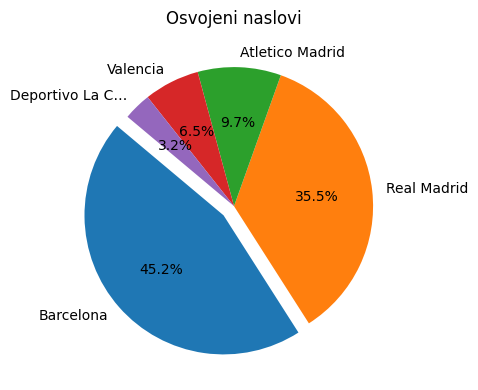

Team
Barcelona          14
Real Madrid        11
Atletico Madrid     3
Valencia            2
Deportivo La C…     1
Name: count, dtype: int64

In [6]:
zmagovalci = laliga_podatki[laliga_podatki['Position'] == 1]
naslovi = zmagovalci['Team'].value_counts()
new_sheet('Sestevek naslovov', naslovi)

# plotanje
plt.figure(figsize=(5, 4))
naslovi.plot.pie(autopct='%1.1f%%', startangle=140, explode=[0.1] + [0]*(len(naslovi)-1))
plt.title('Osvojeni naslovi')
plt.ylabel('')  # Removing the default 'Team' ylabel for better aesthetics
plt.tight_layout()
plt.show()
naslovi

### Seštevek

Za vsako ekipo smo vzeli podatke iz vseh sezon in jih sešteli.
Nato smo vse skupaj razvrstili glede na pridobljene točke in ugotovili,
da je največ točk v sezonah med letom 1993 in 2023 pridobila Barcelona.  

In [7]:
ekipe = laliga_podatki.drop(columns=[col for col in laliga_podatki.columns if 'Unnamed' in col or col == 'H2H'])
ekipe = ekipe.drop(columns=['Season', 'Position', 'Last 5 matches'])
ekipe_vsota_podatkov = ekipe.groupby('Team').sum().sort_values(by='Points', ascending=False).head(15)
new_sheet('Vsota podatkov', ekipe_vsota_podatkov)
ekipe_vsota_podatkov


,Matches Played,Wins,Goal difference,Losses,Goals for,Goals against,Goal difference.1,Points
Team,,,,,,,,
Barcelona,1186,761,235,190,2679,1151,1528,2475
Real Madrid,1186,754,227,205,2579,1229,1350,2447
Atletico Madrid,1110,545,264,301,1771,1210,561,1873
Valencia,1186,519,305,362,1760,1393,367,1835
Athletic Bilbao,1186,443,335,408,1553,1533,20,1632
Sevilla,1072,457,263,352,1541,1317,224,1603
Real Sociedad,1072,406,289,377,1445,1384,61,1483
Villarreal,912,376,241,295,1308,1126,182,1369
Real Betis,996,357,283,356,1262,1333,-71,1339


### Povprecje zmag in točk

Povprecje zmag in točk skozi vse sezone.

In [8]:
ekipe_povprecje = laliga_podatki.groupby('Team')[['Points', 'Wins']].mean()
urejene_ekipe = ekipe_povprecje.sort_values(by='Points', ascending=False)
urejene_ekipe

,Points,Wins
Team,,
Barcelona,79.838710,24.548387
Real Madrid,78.935484,24.322581
Atletico Madrid,64.586207,18.793103
Valencia,59.193548,16.741935
Sevilla,57.250000,16.321429
Villarreal,57.041667,15.666667
Girona,54.500000,15.250000
Deportivo La C…,53.913043,14.956522
Real Sociedad,52.964286,14.500000


### Zbrane točke najboljših 5 ekip med sezonami 1993/94 in 2023/24 

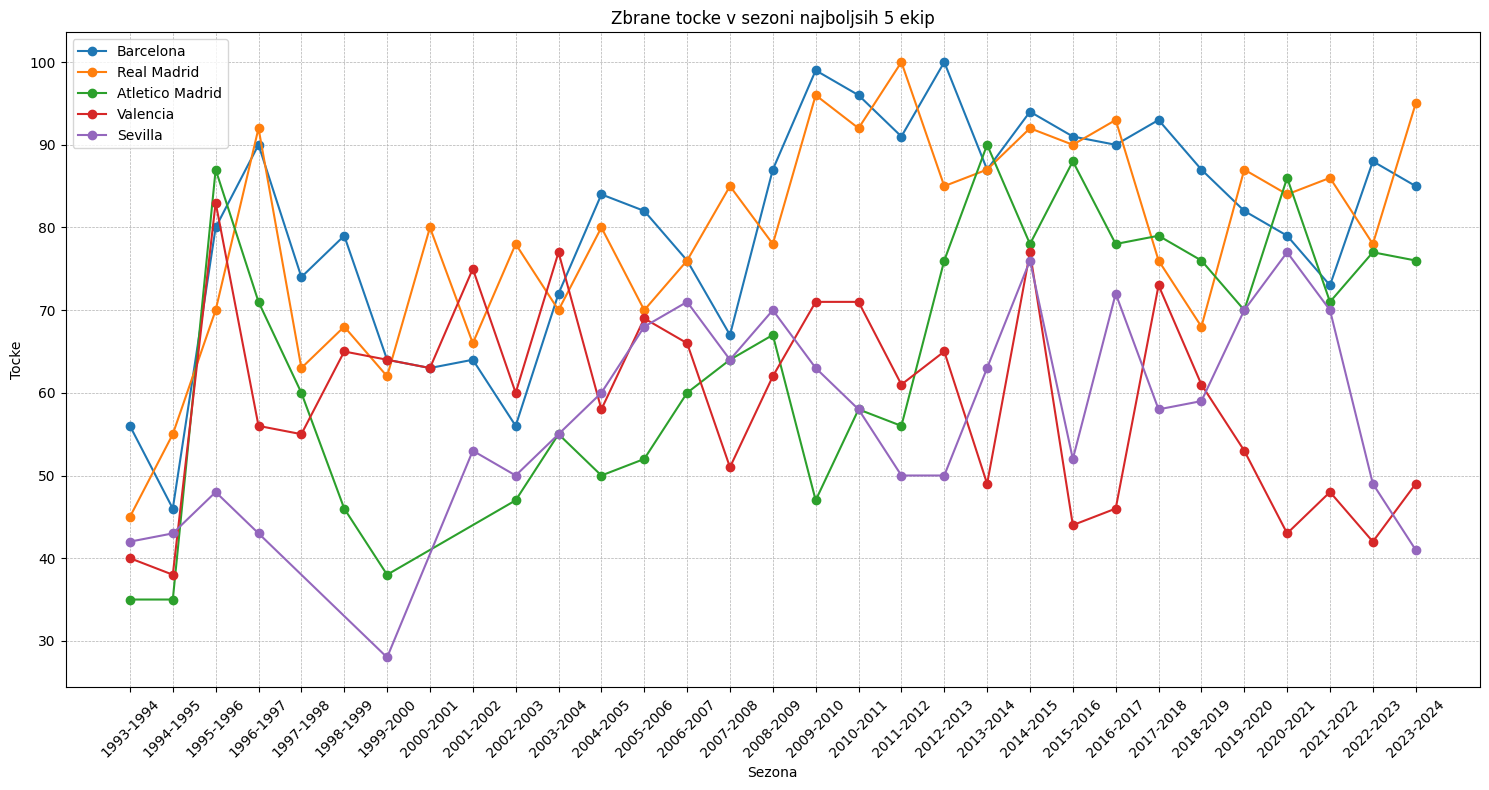

In [9]:


top_5 = urejene_ekipe.sort_values(by='Points', ascending=False).head(5).index
top_5_podatki = laliga_podatki[laliga_podatki['Team'].isin(top_5)]

plt.figure(figsize=(15, 8))

for team in top_5:
    ekipa = top_5_podatki[top_5_podatki['Team'] == team]
    plt.plot(ekipa['Season'], ekipa['Points'], label=team, marker='o')

# plotanje
plt.title('Zbrane tocke v sezoni najboljsih 5 ekip')
plt.xlabel('Sezona')
plt.ylabel('Tocke')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


### Napredovanje oz. izpad iz prve lige

V spodnji kodi smo za posamezno sezono prikazali:

- ekipe ki so napredovale v prvo ligo
- ekipe ki so izpadle iz prve lige

In [10]:
izpadle_ekipe = {}
napredovale_ekipe = {}

sezone = laliga_podatki['Season'].unique()

for i in range(len(sezone) - 1):
    trenutna_sezona = sezone[i]
    naslednja_sezona = sezone[i + 1]
    
    trenutne_ekipe = set(laliga_podatki[laliga_podatki['Season'] == trenutna_sezona]['Team'])
    ekipe = set(laliga_podatki[laliga_podatki['Season'] == naslednja_sezona]['Team'])
    
    izpad = trenutne_ekipe - ekipe
    napredovanje = ekipe - trenutne_ekipe
    
    izpadle_ekipe[trenutna_sezona] = izpad
    napredovale_ekipe[trenutna_sezona] = napredovanje

podatki_ekip = pd.DataFrame({
    'Sezona': list(izpadle_ekipe.keys()),
    'Izpadle ekipe': list(izpadle_ekipe.values()),
    'Napredovane ekipe': list(napredovale_ekipe.values())
})
new_sheet('Napredovanje_izpad',podatki_ekip)

podatki_ekip

,Sezona,Izpadle ekipe,Napredovane ekipe
0,1993-1994,"{Lerida, Rayo Vallecano, Osasuna}","{Espanyol, Compostela, Real Betis}"
1,1994-1995,{CD Logroñés},"{Mérida UD, Rayo Vallecano, UD Salamanca}"
2,1995-1996,"{Albacete, Mérida UD, UD Salamanca}","{CF Extremadura, Hércules, CD Logroñés}"
3,1996-1997,"{CF Extremadura, CD Logroñés, Rayo Vallecano, ...","{Mérida UD, Mallorca, UD Salamanca}"
4,1997-1998,"{Mérida UD, Compostela, Sporting Gijon}","{CF Extremadura, Alaves, Villarreal}"
5,1998-1999,"{CF Extremadura, UD Salamanca, Tenerife, Villa...","{Sevilla, Rayo Vallecano, Malaga, Numancia}"
6,1999-2000,"{Sevilla, Atletico Madrid, Real Betis}","{Osasuna, Villarreal, Las Palmas}"
7,2000-2001,"{Numancia, Real Oviedo, Racing Santander}","{Sevilla, Tenerife, Real Betis}"
8,2001-2002,"{Real Zaragoza, Tenerife, Las Palmas}","{Recreativo Huelva, Racing Santander, Atletico..."
9,2002-2003,"{Recreativo Huelva, Rayo Vallecano, Alaves}","{Albacete, Real Zaragoza, Real Murcia}"


###  Prikaz ekip z največ zadetki po sezonah

Največkrat se pojavita ekipi Barcelona in Real Madrid, ekipi, ki so tudi osvojile največ naslovov.



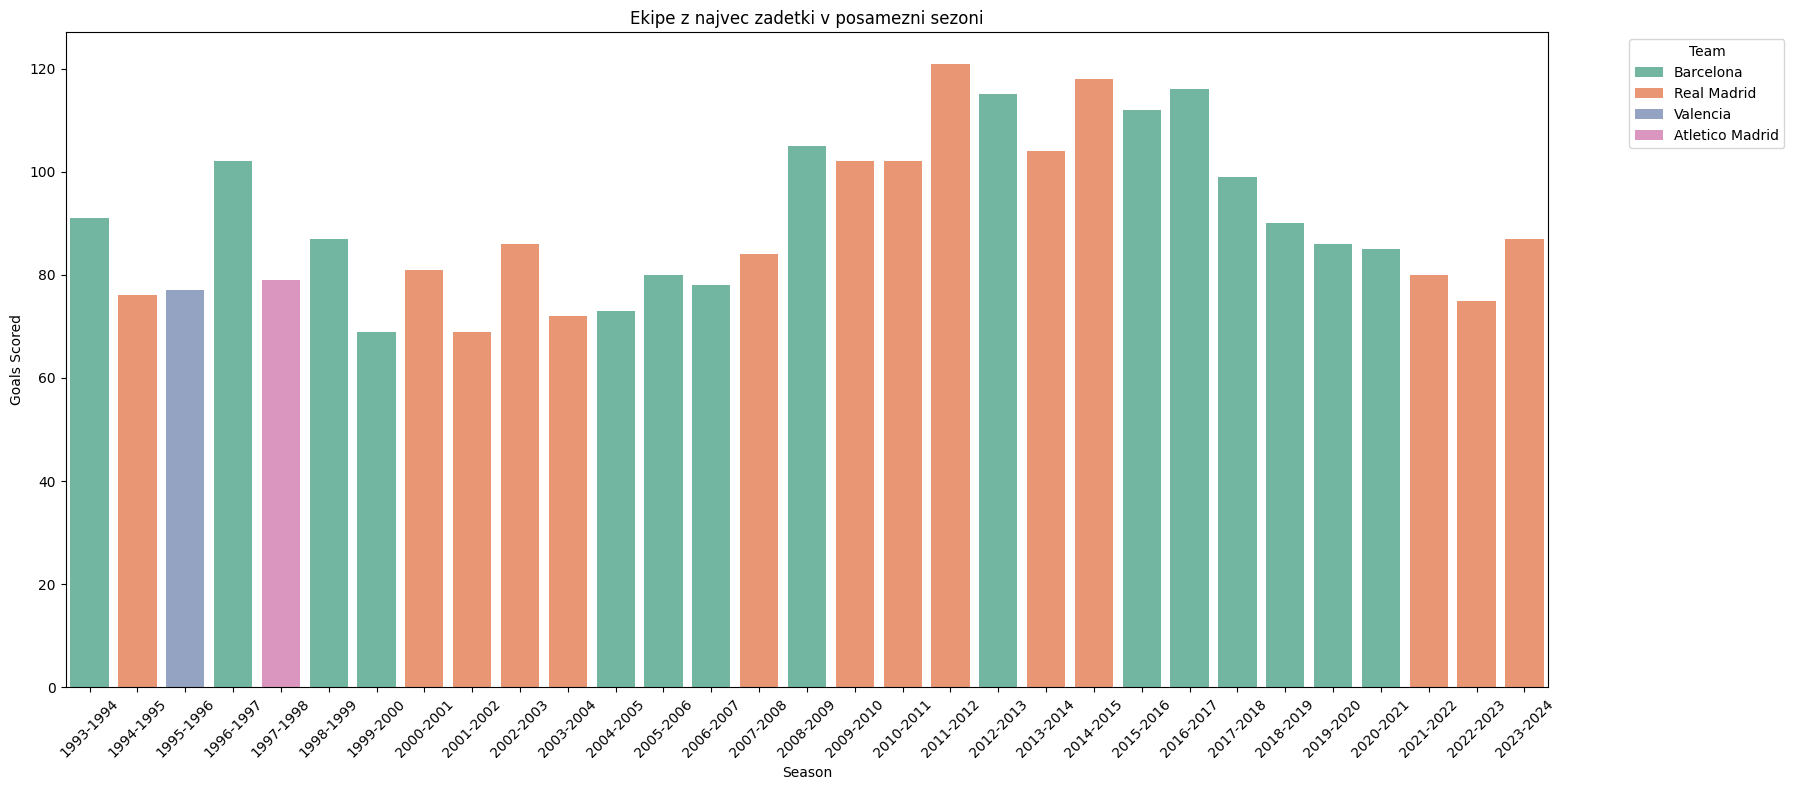

In [11]:
import seaborn as sns
zadetki = laliga_podatki.groupby(['Season', 'Team'])['Goals for'].sum().reset_index()

# za vsako sezono identificiramo ekipo z največ zadetki
ekipa_najvec_zadetkov = zadetki.groupby('Season').apply(lambda x: x.nlargest(1, 'Goals for')).reset_index(drop=True)
new_sheet('Najvecd zadetkov po sezonah',ekipa_najvec_zadetkov)

# plotanje
plt.figure(figsize=(18, 8))
sns.barplot(data=ekipa_najvec_zadetkov, x='Season', y='Goals for', hue='Team', dodge=False, palette='Set2')
plt.title('Ekipe z najvec zadetki v posamezni sezoni')
plt.ylabel('Goals Scored')
plt.xlabel('Season')
plt.legend(title='Team', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()